In [351]:
import matplotlib.pyplot as plt
import mlx.core as mx
import mlx.nn as nn
from mlx.optimizers import Adam, OptimizerState
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import seaborn as sns

sns.set_style("whitegrid", rc={"font.size": 25})

## Consensus

In [517]:
def generate_network(n, p):
    g = nx.fast_gnp_random_graph(n, p)
    while not nx.is_connected(g):
        g = nx.fast_gnp_random_graph(n, p)
    mixing_matrix = np.zeros([n, n])
    adj = nx.adjacency_matrix(g)
    deg = np.sum(adj, 1)
    for u, v in g.edges:
        max_deg = max(deg[u], deg[v])
        mixing_matrix[u, v] = 1 / max_deg
        mixing_matrix[v, u] = 1 / max_deg

    for u in range(n):
        mixing_matrix[u, u] = 1 - mixing_matrix[u].sum()

    return mx.array(mixing_matrix)

In [518]:
def consensus_convergence(n_iters, n_features, n_nodes, p):
    mean_diff = []
    max_diff = []
    low = (-1 / np.sqrt(n_features)).item()
    high = -low
    X = mx.random.uniform(low, high, shape=(n_features, n_nodes))
    X_true = mx.mean(X, 1)[..., None]
    for i in tqdm(range(n_iters), desc="consensus", leave=False):
        mixing_matrix = generate_network(n_nodes, p) 
        X @= mixing_matrix
        diffs = mx.sqrt(mx.sum((X - X_true) ** 2, 0))
        mean_diff.append(np.array(mx.mean(diffs)))
        max_diff.append(np.array(mx.max(diffs)))
    return mean_diff, max_diff

In [519]:
def consensus_convergence_constant_graph(n_iters, n_features, n_nodes, p):
    mean_diff = []
    max_diff = []
    low = (-1 / np.sqrt(n_features)).item()
    high = -low
    X = mx.random.uniform(low, high, shape=(n_features, n_nodes))
    X_true = mx.mean(X, 1)[..., None]
    mixing_matrix = generate_network(n_nodes, p) 
    for i in tqdm(range(n_iters), desc="consensus", leave=False):
        X @= mixing_matrix
        diffs = mx.sqrt(mx.sum((X - X_true) ** 2, 0))
        mean_diff.append(np.array(mx.mean(diffs)))
        max_diff.append(np.array(mx.max(diffs)))
    return mean_diff, max_diff

consensus:   0%|          | 0/50 [00:00<?, ?it/s]

consensus:   0%|          | 0/50 [00:00<?, ?it/s]

consensus:   0%|          | 0/50 [00:00<?, ?it/s]

consensus:   0%|          | 0/50 [00:00<?, ?it/s]

consensus:   0%|          | 0/50 [00:00<?, ?it/s]

consensus:   0%|          | 0/50 [00:00<?, ?it/s]

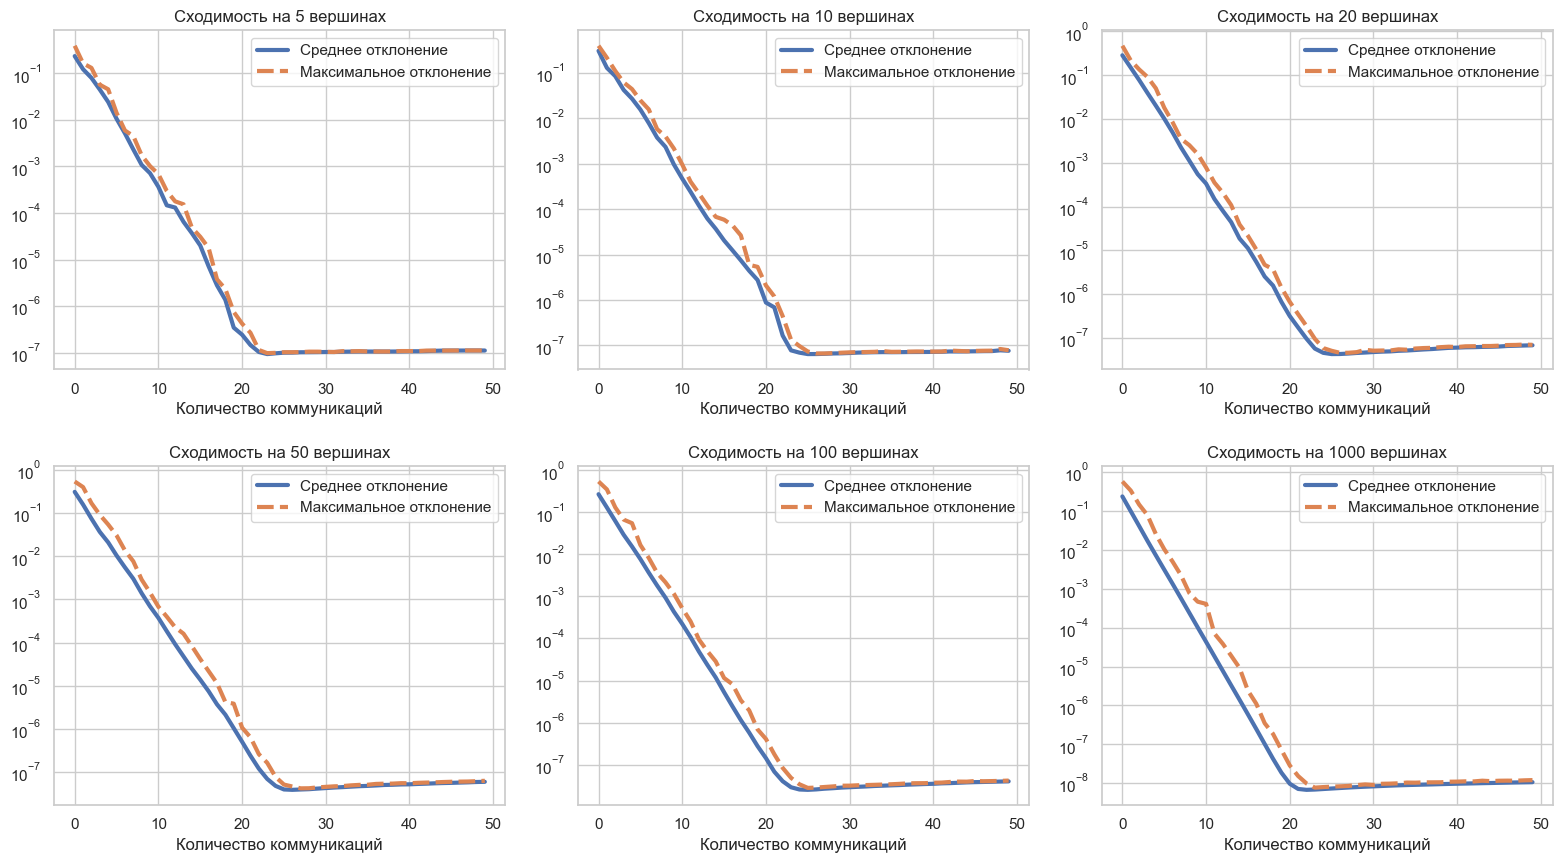

In [520]:
n_features = 100
n_nodes_grid = [5, 10, 20, 50, 100, 1000]
n_iters = 50

plt.figure(figsize=(16, 9))
# plt.suptitle("Сходимость консенсуса на разреженном графе G(n, log(n)/n)", fontsize=14)
for i, n_nodes in enumerate(n_nodes_grid, 1):
    mean_diff, max_diff = consensus_convergence(
        n_iters, n_features, n_nodes, np.log(n_nodes) / n_nodes
    )
    ax = plt.subplot(2, 3, i)
    sns.lineplot({
        "Среднее отклонение": np.array(mean_diff),
        "Максимальное отклонение": np.array(max_diff)
    }, ax=ax, linewidth=3)
    ax.set_xlabel("Количество коммуникаций")
    ax.set_title(f"Сходимость на {n_nodes} вершинах")
    plt.yscale('log')
plt.tight_layout()
plt.savefig("images/consensus_sparse.jpg")

consensus:   0%|          | 0/50 [00:00<?, ?it/s]

consensus:   0%|          | 0/50 [00:00<?, ?it/s]

consensus:   0%|          | 0/50 [00:00<?, ?it/s]

consensus:   0%|          | 0/50 [00:00<?, ?it/s]

consensus:   0%|          | 0/50 [00:00<?, ?it/s]

consensus:   0%|          | 0/50 [00:00<?, ?it/s]

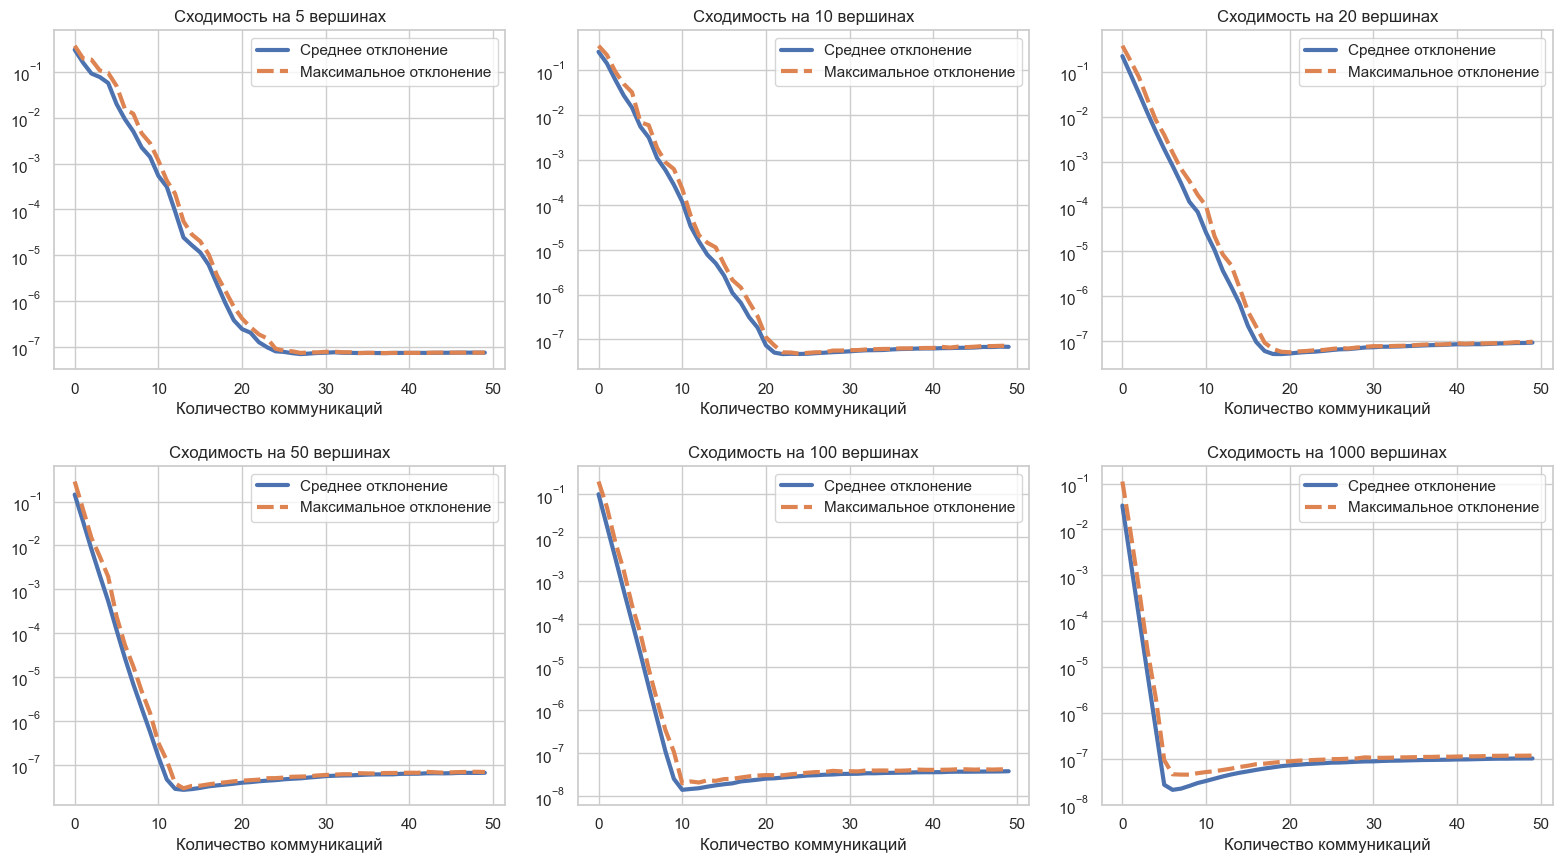

In [524]:
n_features = 100
n_nodes_grid = [5, 10, 20, 50, 100, 1000]
n_iters = 50

plt.figure(figsize=(16, 9))
# plt.suptitle("Сходимость консенсуса на неразреженном графе G(n, 0.3)", fontsize=14)
for i, n_nodes in enumerate(n_nodes_grid, 1):
    mean_diff, max_diff = consensus_convergence(
        n_iters, n_features, n_nodes, 0.3
    )
    ax = plt.subplot(2, 3, i)
    sns.lineplot({
        "Среднее отклонение": np.array(mean_diff),
        "Максимальное отклонение": np.array(max_diff)
    }, ax=ax, linewidth=3)
    ax.set_xlabel("Количество коммуникаций")
    ax.set_title(f"Сходимость на {n_nodes} вершинах")
    plt.yscale('log')
plt.tight_layout()
plt.savefig("images/consensus_dense.jpg")

consensus:   0%|          | 0/300 [00:00<?, ?it/s]

consensus:   0%|          | 0/300 [00:00<?, ?it/s]

consensus:   0%|          | 0/300 [00:00<?, ?it/s]

consensus:   0%|          | 0/300 [00:00<?, ?it/s]

consensus:   0%|          | 0/300 [00:00<?, ?it/s]

consensus:   0%|          | 0/300 [00:00<?, ?it/s]

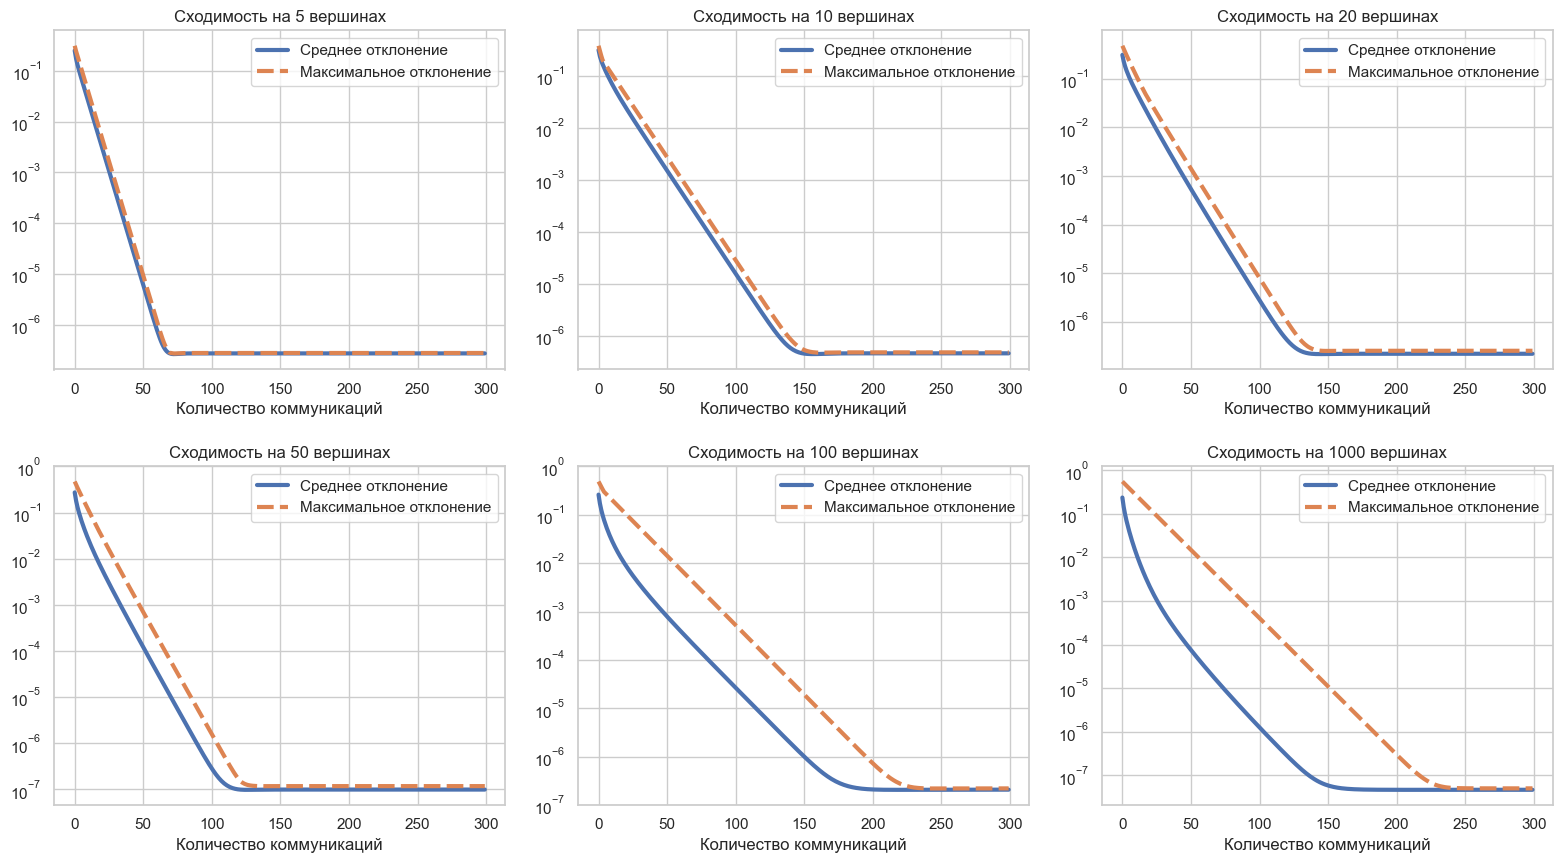

In [525]:
n_features = 700
n_nodes_grid = [5, 10, 20, 50, 100, 1000]
n_iters = 300

plt.figure(figsize=(16, 9))
for i, n_nodes in enumerate(n_nodes_grid, 1):
    mean_diff, max_diff = consensus_convergence_constant_graph(
        n_iters, n_features, n_nodes, np.log(n_nodes) / n_nodes
    )
    ax = plt.subplot(2, 3, i)
    sns.lineplot({
        "Среднее отклонение": np.array(mean_diff),
        "Максимальное отклонение": np.array(max_diff)
    }, ax=ax, linewidth=3)
    ax.set_xlabel("Количество коммуникаций")
    ax.set_title(f"Сходимость на {n_nodes} вершинах")
    plt.yscale('log')
plt.tight_layout()
plt.savefig("images/consensus_sparse_constant_graph.jpg")

consensus:   0%|          | 0/300 [00:00<?, ?it/s]

consensus:   0%|          | 0/300 [00:00<?, ?it/s]

consensus:   0%|          | 0/300 [00:00<?, ?it/s]

consensus:   0%|          | 0/300 [00:00<?, ?it/s]

consensus:   0%|          | 0/300 [00:00<?, ?it/s]

consensus:   0%|          | 0/300 [00:00<?, ?it/s]

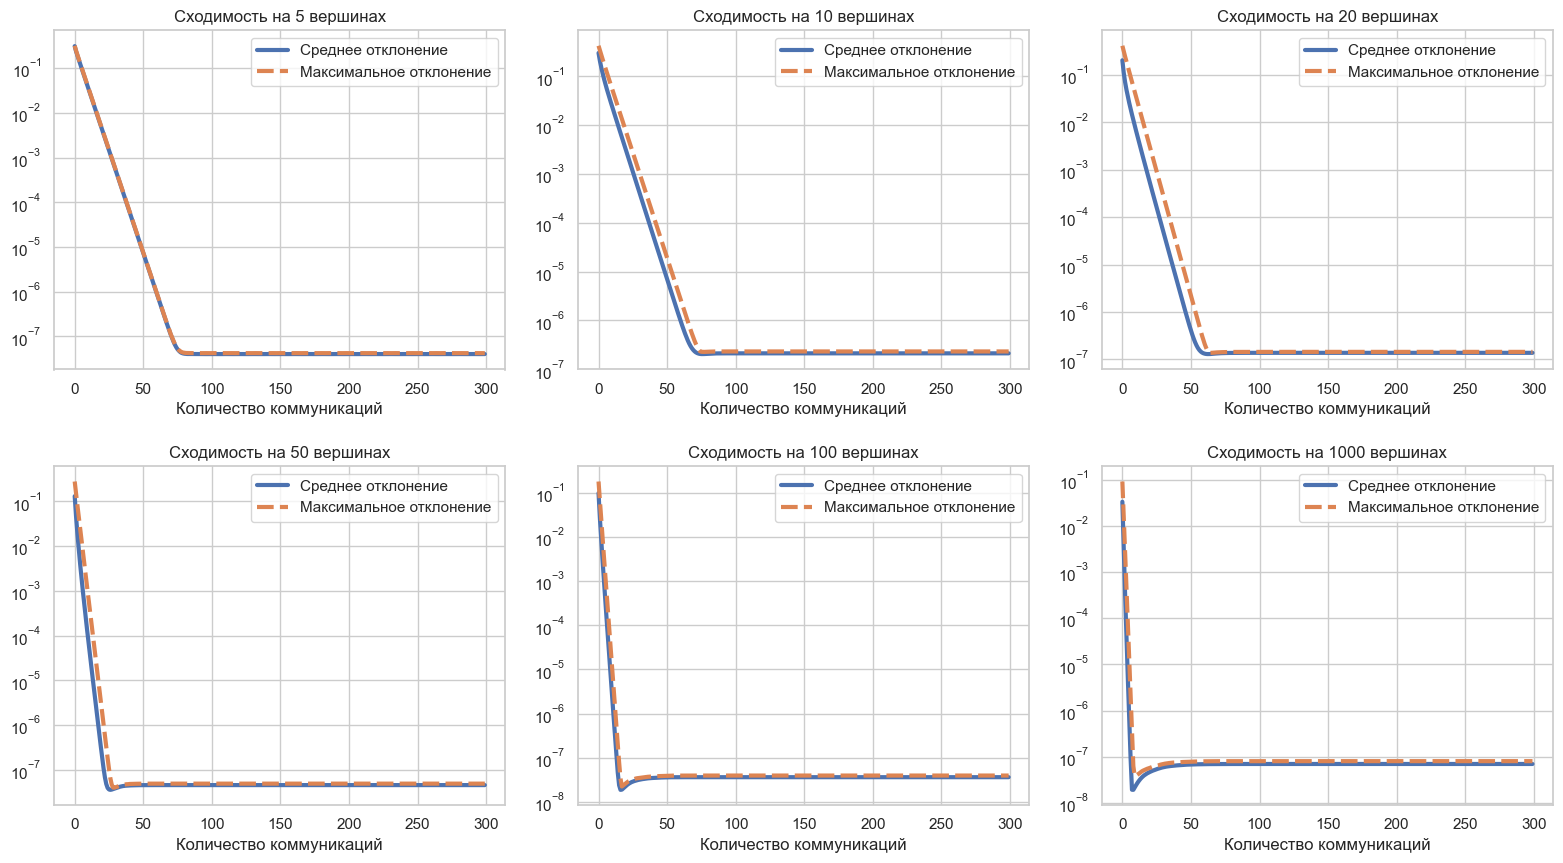

In [526]:
n_features = 700
n_nodes_grid = [5, 10, 20, 50, 100, 1000]
n_iters = 300

plt.figure(figsize=(16, 9))
for i, n_nodes in enumerate(n_nodes_grid, 1):
    mean_diff, max_diff = consensus_convergence_constant_graph(
        n_iters, n_features, n_nodes, 0.3
    )
    ax = plt.subplot(2, 3, i)
    sns.lineplot({
        "Среднее отклонение": np.array(mean_diff),
        "Максимальное отклонение": np.array(max_diff)
    }, ax=ax, linewidth=3)
    ax.set_xlabel("Количество коммуникаций")
    ax.set_title(f"Сходимость на {n_nodes} вершинах")
    plt.yscale('log')
plt.tight_layout()
plt.savefig("images/consensus_dense_constant_graph.jpg")

## Линейная регрессия

In [24]:
def predict(weight, X):
    return X @ weight

In [430]:
def cross_entropy(weight, X_train, y_train, c=1.0):
    y_pred = predict(weight, X_train)
    ce_loss = nn.losses.cross_entropy(y_pred, y_train, reduction='mean')
    reg = mx.sum(weight[:-1] ** 2)
    return ce_loss + 1 / c * reg


def binary_cross_entropy(weight, X_train, y_train, c=1.0):
    y_pred = mx.sigmoid(predict(weight, X_train))
    y_pred = mx.maximum(y_pred, 1e-3)
    y_pred = mx.minimum(y_pred, 1 - 1e-3)
    bce_loss = nn.losses.binary_cross_entropy(y_pred, y_train, reduction='mean')
    reg = mx.sum(weight[:-1] ** 2)
    return bce_loss + 1 / c * reg

cross_entropy_grad_fn = mx.grad(cross_entropy)
binary_cross_entropy_grad_fn = mx.grad(binary_cross_entropy)

In [431]:
def build_plot_binary_classification(history):
    data = pd.DataFrame(history)
    metrics = ["accuracy", "precision", "recall", "f1-score", "roc-auc"]
    for metric in metrics:
        sns.lineplot(
            data=data, x="step", y=metric, legend="full", label=metric
        )
    plt.xlabel("Шаг градиентного спуска")
    plt.ylabel("Значение метрики")
    plt.legend()

In [465]:
class DecentralizedLogisticRegression:
    def __init__(self, n_nodes, n_communications=30, c=1.0, n_classes=2, lr=1e-3):
        self.n_nodes = n_nodes
        self.n_communications = n_communications
        self.lr = lr
        self.seed = 0
        self.optimizer = Adam(lr)
        self.states = [OptimizerState() for _ in range(self.n_nodes)]
        self.n_classes = n_classes
        self.c = c

    def consensus(self):
        if self.n_nodes == 1:
            return
        self.weights = self.weights.reshape(self.n_nodes, -1)
        for i in range(self.n_communications):
            mixing_matrix = self.generate_network() 
            self.weights = mixing_matrix @ self.weights
        self.weights = self.weights.reshape(self.n_nodes, -1, self.n_classes)

    def step(self):
        for node_id in range(self.n_nodes):
            self.step_node(node_id)
        self.consensus()

    def step_node(self, node_id):
        grad = cross_entropy_grad_fn(
            self.weights[node_id], self.x_data[node_id], self.y_data[node_id],
            self.c
        )
        if np.isnan(np.array(grad)).any():
            raise ValueError("fuckup in grad")
        grad_norm = mx.sqrt(mx.sum(grad ** 2))
        if grad_norm >= 1.0:
            grad = grad / grad_norm
        self.weights[node_id] = self.optimizer.apply_single(
            grad, self.weights[node_id], self.states[node_id]
        )

    def train(self, n_steps, X_train, y_train, X_val, y_val):
        X_train = np.c_[X_train, np.ones(len(X_train))]
        X_val = np.c_[X_val, np.ones(len(X_val))]
        
        self.n_features = X_train.shape[1]

        # xavier uniform initialization
        low = (-np.sqrt(6) / np.sqrt(self.n_features + self.n_classes)).item()
        high = -low
        self.weights = mx.random.uniform(
            low, high, [self.n_nodes, self.n_features, self.n_classes]
        )
        
        self.x_data = list(map(mx.array, np.array_split(X_train, self.n_nodes)))
        self.y_data = list(map(mx.array, np.array_split(y_train, self.n_nodes)))
        
        X_train = mx.array(X_train)
        X_val = mx.array(X_val)
        
        train_history = []
        val_history = []
        
        for step in tqdm(range(n_steps), "iterate over steps"):
            self.step()

            if step % 5 == 0:
                train_report = self._evaluate(X_train, y_train)
                train_report["step"] = step
                val_report = self._evaluate(X_val, y_val)
                val_report["step"] = step                
                train_history.append(train_report)
                val_history.append(val_report)

        return train_history, val_history

    def _evaluate(self, X, y):
        y_pred = np.argmax(np.array(predict(self.weights[0], X)), -1)
        target_names = [f"class {i}" for i in range(self.n_classes)]
        report = classification_report(y, y_pred, 
                                       target_names=target_names, 
                                       output_dict=True)
        return report
    
    def generate_network(self):
        p = np.log(self.n_nodes) / self.n_nodes
        g = nx.fast_gnp_random_graph(self.n_nodes, p, self.seed)
        self.seed += 1
        while not nx.is_connected(g):
            g = nx.fast_gnp_random_graph(self.n_nodes, p, self.seed)
            self.seed += 1
        mixing_matrix = np.zeros([self.n_nodes, self.n_nodes])
        adj = nx.adjacency_matrix(g)
        deg = np.sum(adj, 1)
        for u, v in g.edges:
            max_deg = max(deg[u], deg[v])
            mixing_matrix[u, v] = 1 / max_deg
            mixing_matrix[v, u] = 1 / max_deg

        for u in range(self.n_nodes):
            mixing_matrix[u, u] = 1 - mixing_matrix[u].sum()

        return mx.array(mixing_matrix)

    def predict(self, X):
        X = mx.array(np.c_[X, np.ones(len(X))])
        return predict(self.weights[0], X)

In [433]:
class DecentralizedBinaryLogisticRegression:
    def __init__(self, n_nodes, n_communications=30, c=1.0, lr=1e-3):
        self.n_nodes = n_nodes
        self.n_communications = n_communications
        self.optimizer = Adam(lr)
        self.states = [OptimizerState() for _ in range(self.n_nodes)]
        self.seed = 0
        self.c = c

    def consensus(self):
        if self.n_nodes == 1:
            return
        for i in range(self.n_communications):
            mixing_matrix = self.generate_network() 
            self.weights = mixing_matrix @ self.weights

    def step(self):
        for node_id in range(self.n_nodes):
            self.step_node(node_id)
        self.consensus()

    def step_node(self, node_id):
        grad = binary_cross_entropy_grad_fn(
            self.weights[node_id], self.x_data[node_id], self.y_data[node_id],
            self.c
        )
        if np.isnan(np.array(grad)).any():
            raise ValueError("fuckup in grad")
        grad_norm = mx.sqrt(mx.sum(grad ** 2))
        if grad_norm >= 1.0:
            grad = grad / grad_norm
        self.weights[node_id] = self.optimizer.apply_single(
            grad, self.weights[node_id], self.states[node_id]
        )

    def train(self, n_steps, X_train, y_train, X_val, y_val):
        X_train = np.c_[X_train, np.ones(len(X_train))]
        X_val = np.c_[X_val, np.ones(len(X_val))]
        
        self.n_features = X_train.shape[1]

        low = (-np.sqrt(1) / np.sqrt(self.n_features)).item()
        high = -low
        self.weights = mx.random.uniform(
            low, high, [self.n_nodes, self.n_features]
        )
        
        self.x_data = list(map(mx.array, np.array_split(X_train, self.n_nodes)))
        self.y_data = list(map(mx.array, np.array_split(y_train, self.n_nodes)))
        if np.isnan(np.array(self.weights[0])).any():
            raise ValueError("fuckup")

        X_train = mx.array(X_train)
        X_val = mx.array(X_val)
        
        train_history = []
        val_history = []
        
        for step in tqdm(range(n_steps), "iterate over steps"):
            self.step()
            if step % 5 == 0:
                train_report = self._evaluate(X_train, y_train)
                train_report["step"] = step
                val_report = self._evaluate(X_val, y_val)
                val_report["step"] = step                
                train_history.append(train_report)
                val_history.append(val_report)

        return train_history, val_history

    def _evaluate(self, X, y):
        y_pred = np.array(predict(self.weights[0], X))
        report = classification_report(y, y_pred >= 0, 
                                       output_dict=True)
        accuracy = report["accuracy"]
        report = report["1"]
        report["roc-auc"] = roc_auc_score(y, y_pred)
        report["accuracy"] = accuracy
        return report
    
    def generate_network(self):
        p = np.log(self.n_nodes) / self.n_nodes
        g = nx.fast_gnp_random_graph(self.n_nodes, p, self.seed)
        self.seed += 1
        while not nx.is_connected(g):
            g = nx.fast_gnp_random_graph(self.n_nodes, p, self.seed)
            self.seed += 1
        mixing_matrix = np.zeros([self.n_nodes, self.n_nodes])
        adj = nx.adjacency_matrix(g)
        deg = np.sum(adj, 1)
        for u, v in g.edges:
            max_deg = max(deg[u], deg[v])
            mixing_matrix[u, v] = 1 / max_deg
            mixing_matrix[v, u] = 1 / max_deg

        for u in range(self.n_nodes):
            mixing_matrix[u, u] = 1 - mixing_matrix[u].sum()

        return mx.array(mixing_matrix)

    def predict(self, X):
        X = mx.array(np.c_[X, np.ones(len(X))])
        return mx.sigmoid(predict(self.weights[0], X))

In [434]:
X, y = make_classification(
    5000, n_features=100, n_informative=95, n_redundant=5, random_state=1
)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=1)

In [435]:
model_30 = DecentralizedBinaryLogisticRegression(100, 30, 10.0, 1e-3)
train_history, val_history = model.train(200, X_train, y_train, X_val, y_val)

iterate over steps:   0%|          | 0/200 [00:00<?, ?it/s]

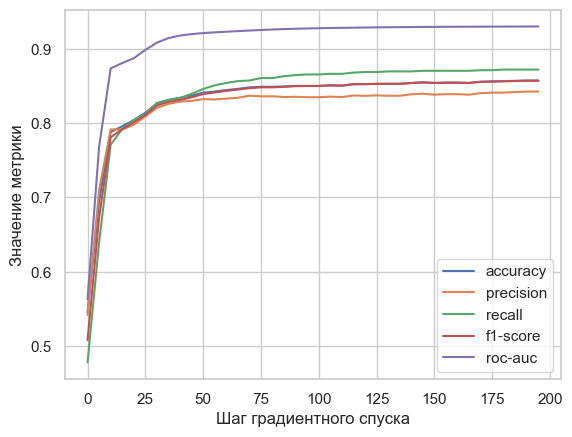

In [436]:
build_plot_binary_classification(train_history)

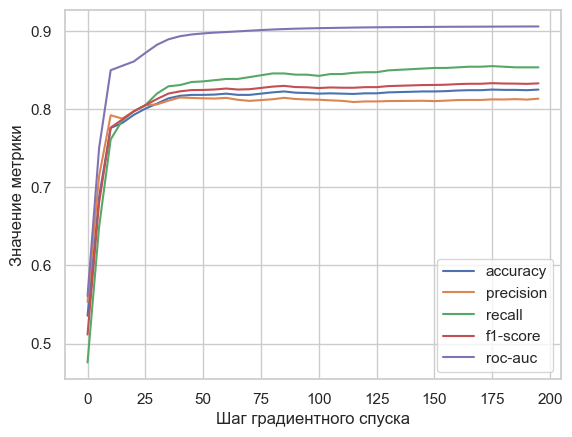

In [437]:
build_plot_binary_classification(val_history)

In [439]:
model_10 = DecentralizedBinaryLogisticRegression(100, 10, c=20.0, lr=1e-3)
train_history_10, val_history_10 = model.train(200, X_train, y_train, X_val, y_val)

iterate over steps:   0%|          | 0/200 [00:00<?, ?it/s]

In [441]:
model_1 = DecentralizedBinaryLogisticRegression(100, 1, c=20.0, lr=1e-3)
train_history_1, val_history_1 = model.train(200, X_train, y_train, X_val, y_val)

iterate over steps:   0%|          | 0/200 [00:00<?, ?it/s]

In [443]:
model_0 = DecentralizedBinaryLogisticRegression(100, 0, c=20.0, lr=1e-3)
train_history_0, val_history_0 = model.train(200, X_train, y_train, X_val, y_val)

iterate over steps:   0%|          | 0/200 [00:00<?, ?it/s]

In [449]:
baseline_model = DecentralizedBinaryLogisticRegression(1, c=20.0, lr=1e-2)
baseline_train_history, baseline_val_history = baseline_model.train(200, X_train, y_train, X_val, y_val)

iterate over steps:   0%|          | 0/200 [00:00<?, ?it/s]

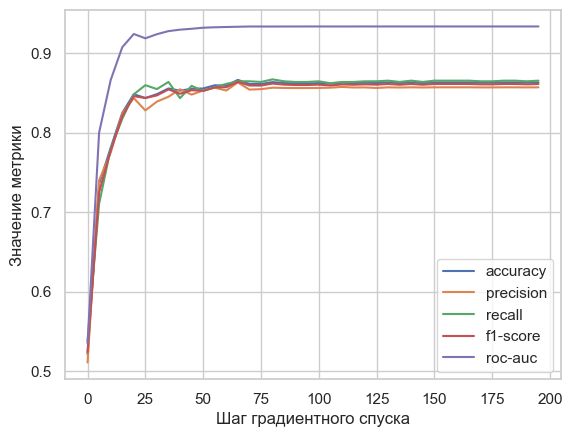

In [450]:
build_plot_binary_classification(baseline_train_history)

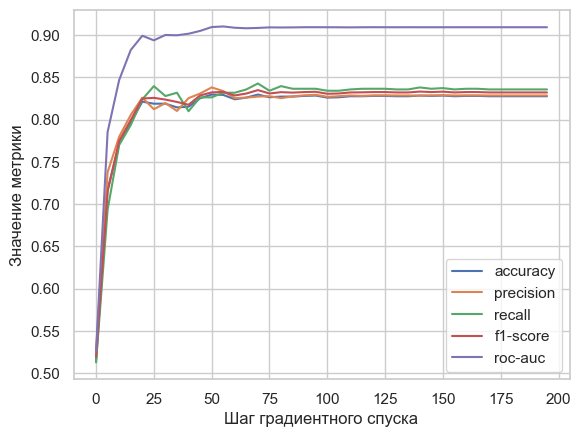

In [451]:
build_plot_binary_classification(baseline_val_history)

In [452]:
def joint_plot(history_list, labels):
    datas = list(map(pd.DataFrame, history_list))
    for i, label in enumerate(labels):
        datas[i]["Алгоритм"] = label
    
    merged_data = pd.concat(datas)
    metrics = ["accuracy", "precision", "recall", "f1-score", "roc-auc"]

    plt.figure(figsize=(16, 16))
    for index, metric in enumerate(metrics, 1):
        ax = plt.subplot(3, 2, index)
        sns.lineplot(
            data=merged_data, x="step", y=metric, legend="full",
            hue="Алгоритм", ax=ax, linewidth=3
        )
        ax.set_xlabel("Шаг градиентного спуска")
    plt.legend()

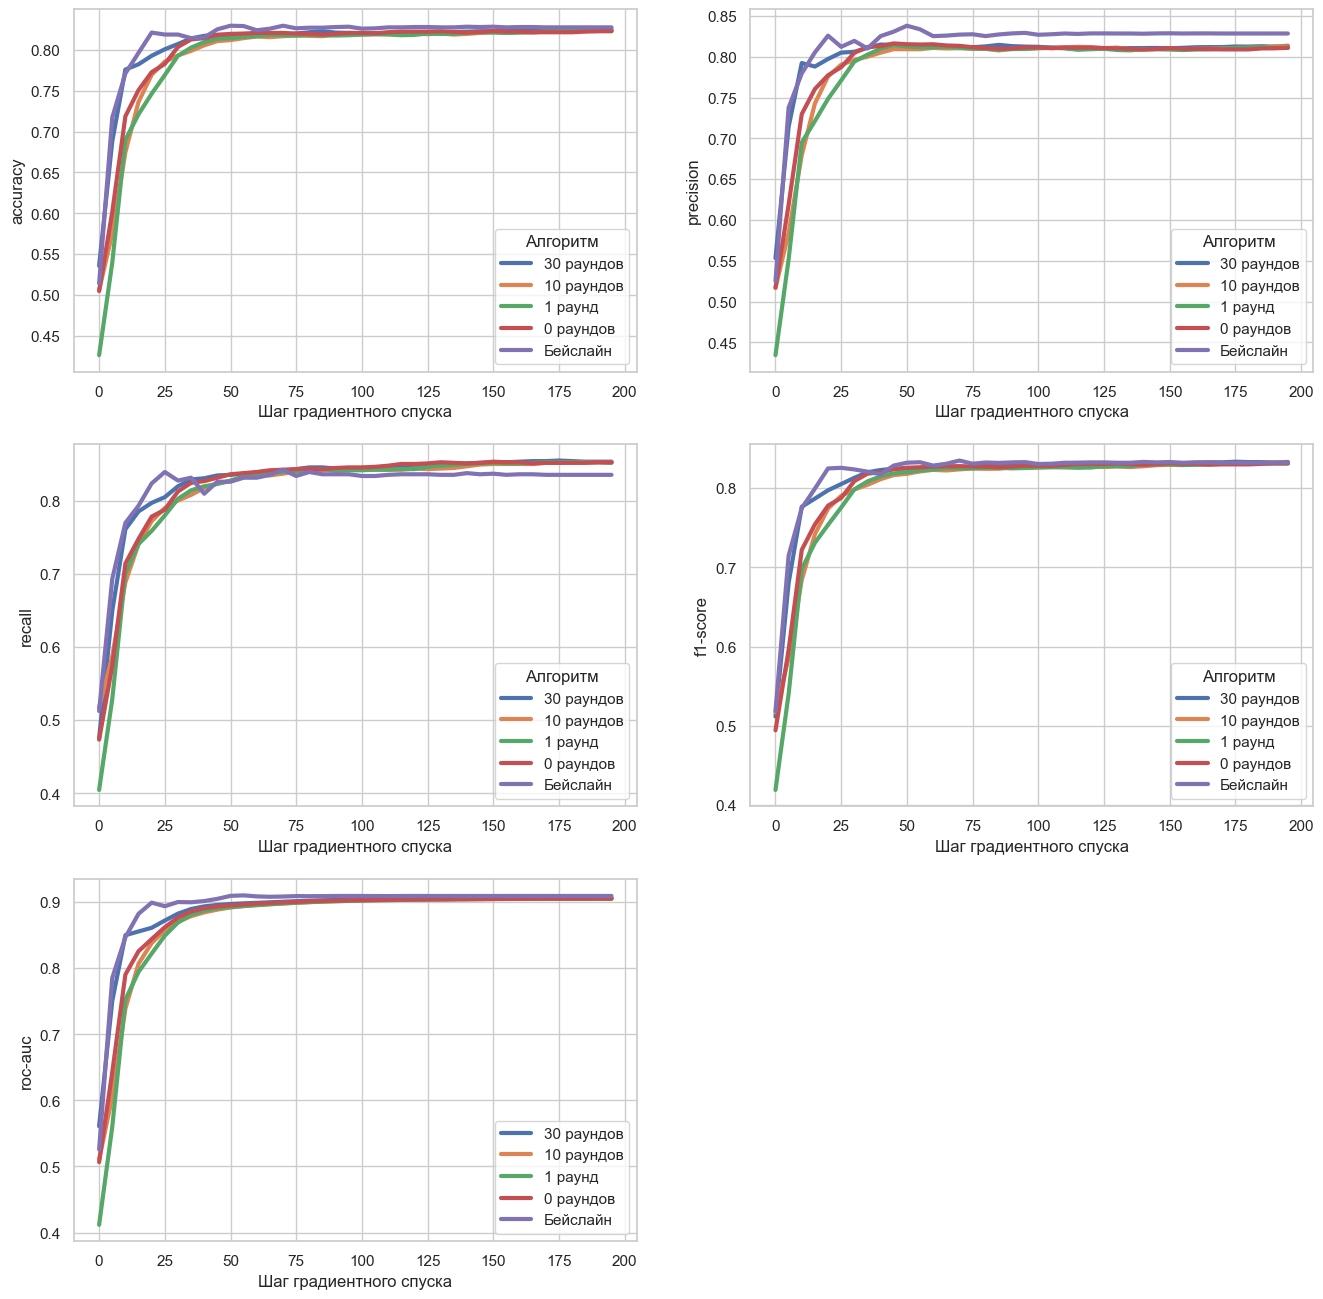

In [453]:
joint_plot(
    [val_history, val_history_10, val_history_1, val_history_0, baseline_val_history],
    ["30 раундов", "10 раундов", "1 раунд", "0 раундов", "Бейслайн"]
)
plt.savefig("./images/joint_plot_generated.jpg")

## Тестирование на MNIST

In [454]:
X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)

In [455]:
X.shape, y.shape

((70000, 784), (70000,))

In [456]:
y = y.astype(int)

In [479]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=20000, test_size=10000, random_state=1
)

In [480]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [481]:
model = DecentralizedLogisticRegression(100, 0, c=20.0, n_classes=10)
_, val_history_0 = model.train(200, X_train, y_train, X_val, y_val)

iterate over steps:   0%|          | 0/200 [00:00<?, ?it/s]

In [482]:
model = DecentralizedLogisticRegression(100, 1, c=20.0, n_classes=10)
_, val_history_1 = model.train(200, X_train, y_train, X_val, y_val)

iterate over steps:   0%|          | 0/200 [00:00<?, ?it/s]

In [483]:
model = DecentralizedLogisticRegression(100, 10, c=20.0, n_classes=10)
_, val_history_10 = model.train(200, X_train, y_train, X_val, y_val)

iterate over steps:   0%|          | 0/200 [00:00<?, ?it/s]

In [484]:
model = DecentralizedLogisticRegression(100, 30, c=20.0, n_classes=10)
_, val_history_30 = model.train(200, X_train, y_train, X_val, y_val)

iterate over steps:   0%|          | 0/200 [00:00<?, ?it/s]

In [494]:
model = DecentralizedLogisticRegression(1, 10, c=20.0, n_classes=10, lr=1e-3)
_, val_history_baseline = model.train(200, X_train, y_train, X_val, y_val)

iterate over steps:   0%|          | 0/200 [00:00<?, ?it/s]

In [511]:
val_history_baseline[0]["macro avg"]

{'precision': 0.12046131441627361,
 'recall': 0.1276738570430264,
 'f1-score': 0.12281993114188458,
 'support': 10000.0}

In [514]:
def joint_plot_classification(history_list, labels):
    def process_history(history):
        return [{
            "step": x["step"],
            "accuracy": x["accuracy"],
            "macro-avg-precision": x["macro avg"]["precision"],
            "macro-avg-recall": x["macro avg"]["recall"],
            "macro-avg-f1-score": x["macro avg"]["f1-score"],
        } for x in history]
    datas = list(map(
        pd.DataFrame, map(process_history, history_list)
    ))
    for i, label in enumerate(labels):
        datas[i]["Алгоритм"] = label
    
    merged_data = pd.concat(datas)
    metrics = ["accuracy", "macro-avg-precision", "macro-avg-recall", "macro-avg-f1-score"]

    plt.figure(figsize=(16, 16))
    for index, metric in enumerate(metrics, 1):
        ax = plt.subplot(2, 2, index)
        sns.lineplot(
            data=merged_data, x="step", y=metric, legend="full",
            hue="Алгоритм", ax=ax, linewidth=3
        )
        ax.set_xlabel("Шаг градиентного спуска")
    plt.legend()

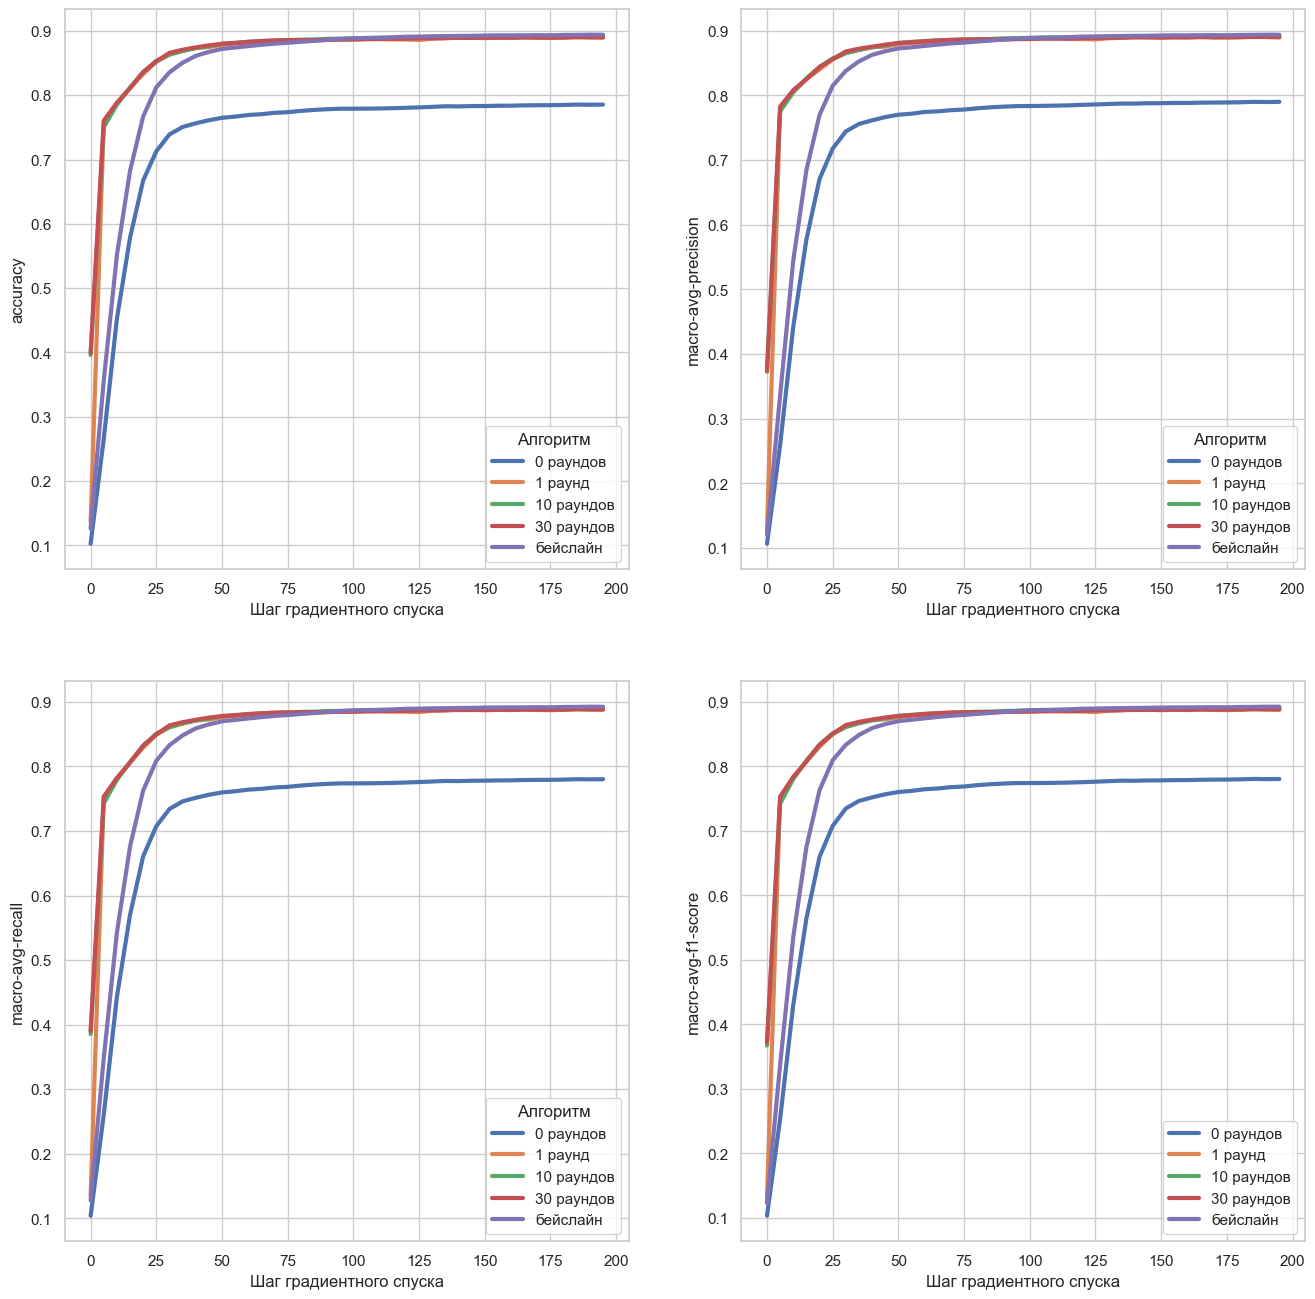

In [516]:
joint_plot_classification(
    [val_history_0, val_history_1, val_history_10, val_history_30, val_history_baseline],
    ["0 раундов", "1 раунд", "10 раундов", "30 раундов", "бейслайн"]
)
plt.savefig("images/MNIST_result.jpg", bbox_inches="tight")